In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Drake Passage averages over the last 1000 days

In [3]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_smooth_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_reynolds_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/longmean_00029050.nc', decode_times=False).mean('time')

M4_smooth_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-3.0/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_reynolds_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-3.0/output/longmean_00029050.nc', decode_times=False).mean('time')

M4_JH = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_yankovsky_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_yankovsky_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23-0.3/output/longmean_00029050.nc', decode_times=False).mean('time')

M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [22]:
#selector = lambda x: x.isel(xh=0)
#selector = lambda x: x.interp(xh=30)
selector = lambda x: x.interp(xh=45)

e32 = selector(M32.e).mean('time').compute()
e4 = selector(M4.e).compute()

e4_smooth_weak = selector(M4_smooth_weak.e).compute()
e4_reynolds_weak = selector(M4_reynolds_weak.e).compute()

e4_smooth_strong = selector(M4_smooth_strong.e).compute()
e4_reynolds_strong = selector(M4_reynolds_strong.e).compute()

e4_JH = selector(M4_JH.e).compute()
e4_yankovsky_weak = selector(M4_yankovsky_weak.e).compute()
e4_yankovsky_strong = selector(M4_yankovsky_strong.e).compute()

e32 = e32.interp(yh=e4.yh)

In [15]:
def plot_interfaces(e, target=e32, xtext=-44, ytext=-3900):
    for zi in range(15):
        e.isel(zi=zi).plot(ls='--', color='blue', lw=2)
        target.isel(zi=zi).plot(ls='-', color='k', lw=2, alpha=0.5)
    e.isel(zi=-1).plot(color='k') # show bathymetry 
    
    error = (e - target).isel(zi=slice(0,15))
    RMSE = np.sqrt((error**2).mean()) # RMSE in metres
    plt.text(xtext,ytext,'RMSE=\n'+"{:.1f}".format(RMSE)+'$\,\mathrm{m}$', fontsize=15)
    plt.xlabel('Latitude, $^{\circ}\mathrm{S}$')
    plt.yticks(np.arange(-4000,1000,1000), np.arange(4000,-1000,-1000))
    plt.ylabel('Depth, $\mathrm{m}$')
    plt.title('')


def plot_interfaces_Drake(e, target=e32):
    plot_interfaces(e,target)
    
    lats = [-60, -50, -40]
    plt.xticks(lats, [f'${-j}$' for j in lats], rotation=0)
    plt.xlim([-61,-39])
    
    # Layer number
    xoff = {2:-42,5:-45,7:-48,9:-50,11:-51,13:-52}
    for k,x in xoff.items():
        plt.text( x, e32.sel(yh=x,method='nearest')[k:k+2].mean(), '%i'%(k+1), verticalalignment='center', fontsize=13)


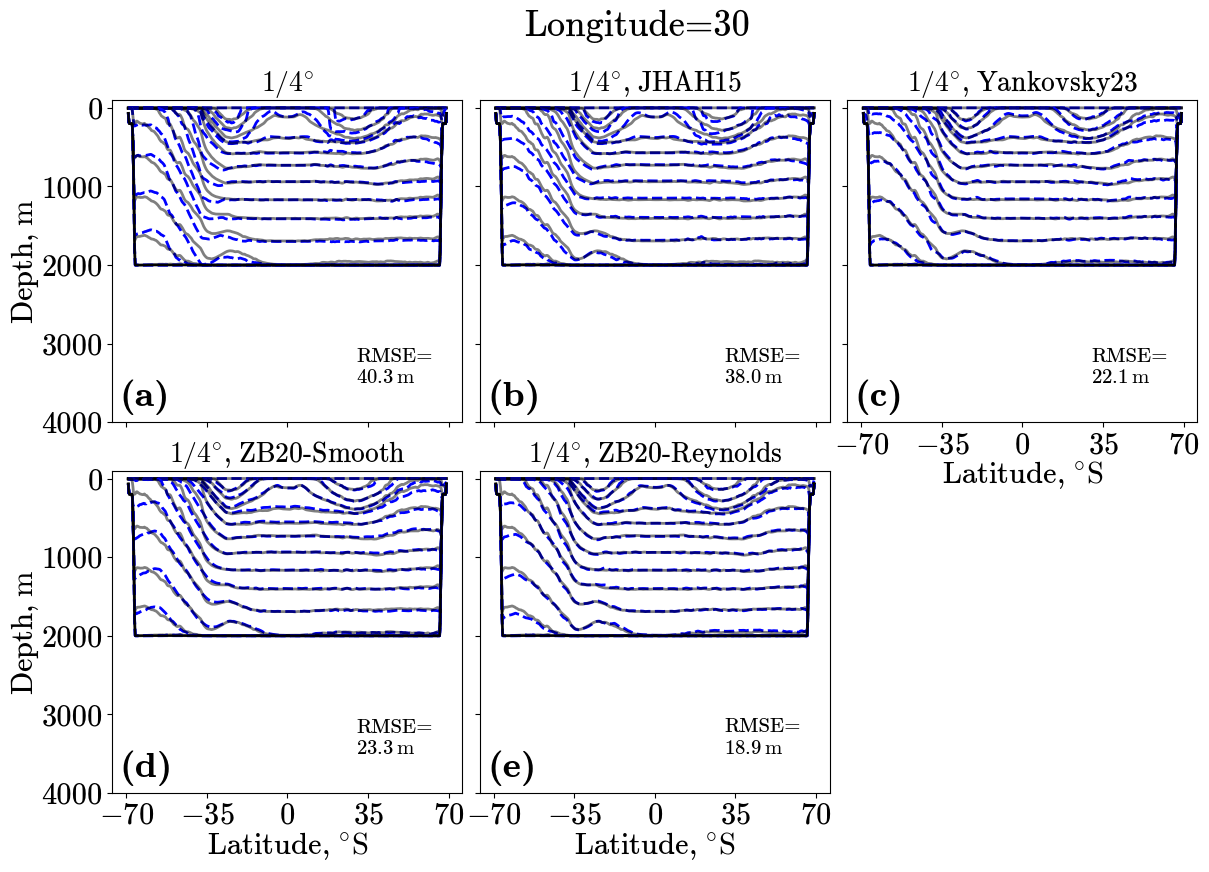

In [20]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(14,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_yankovsky_strong, e4_smooth_strong, e4_reynolds_strong], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,3,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    if col==1 or col==2 or col==4:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-70,-35,0,35,70], [None]*5)
    else:
        plt.xticks([-70,-35,0,35,70])

plt.suptitle('Longitude=30')

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('Review-2/lon30-strong.pdf')

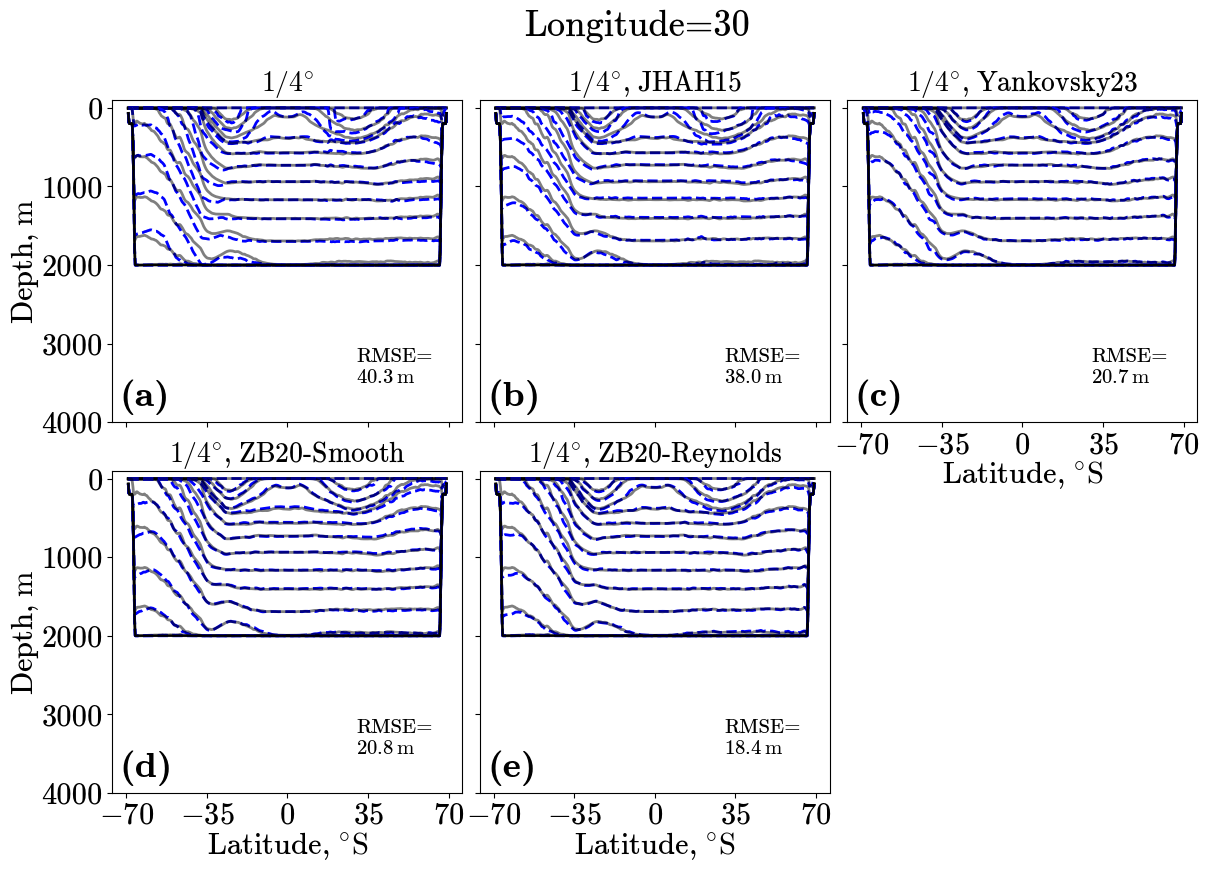

In [21]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(14,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_yankovsky_weak, e4_smooth_weak, e4_reynolds_weak], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,3,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    if col==1 or col==2 or col==4:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-70,-35,0,35,70], [None]*5)
    else:
        plt.xticks([-70,-35,0,35,70])

plt.suptitle('Longitude=30')

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('Review-2/lon30-weak.pdf')

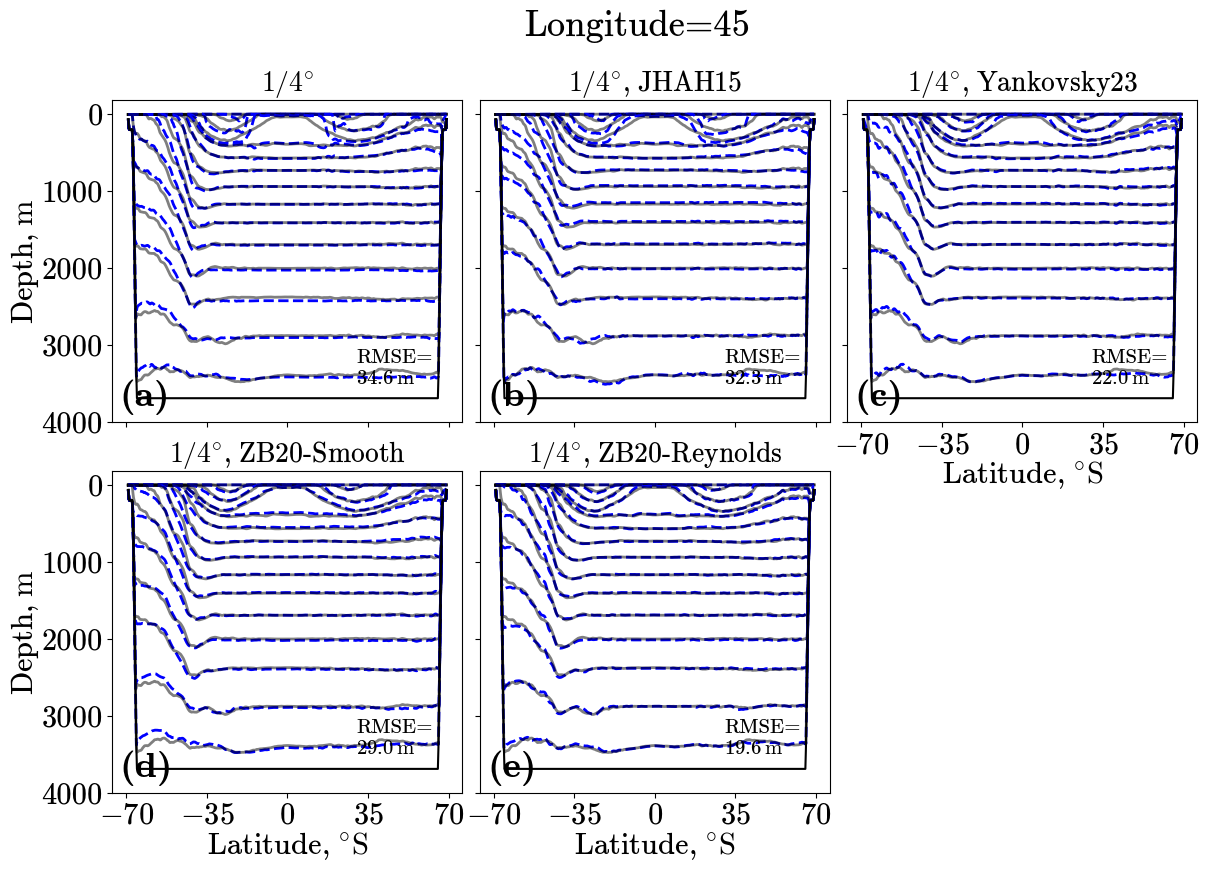

In [23]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(14,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_yankovsky_strong, e4_smooth_strong, e4_reynolds_strong], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,3,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    if col==1 or col==2 or col==4:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-70,-35,0,35,70], [None]*5)
    else:
        plt.xticks([-70,-35,0,35,70])

plt.suptitle('Longitude=45')

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('Review-2/lon45-strong.pdf')

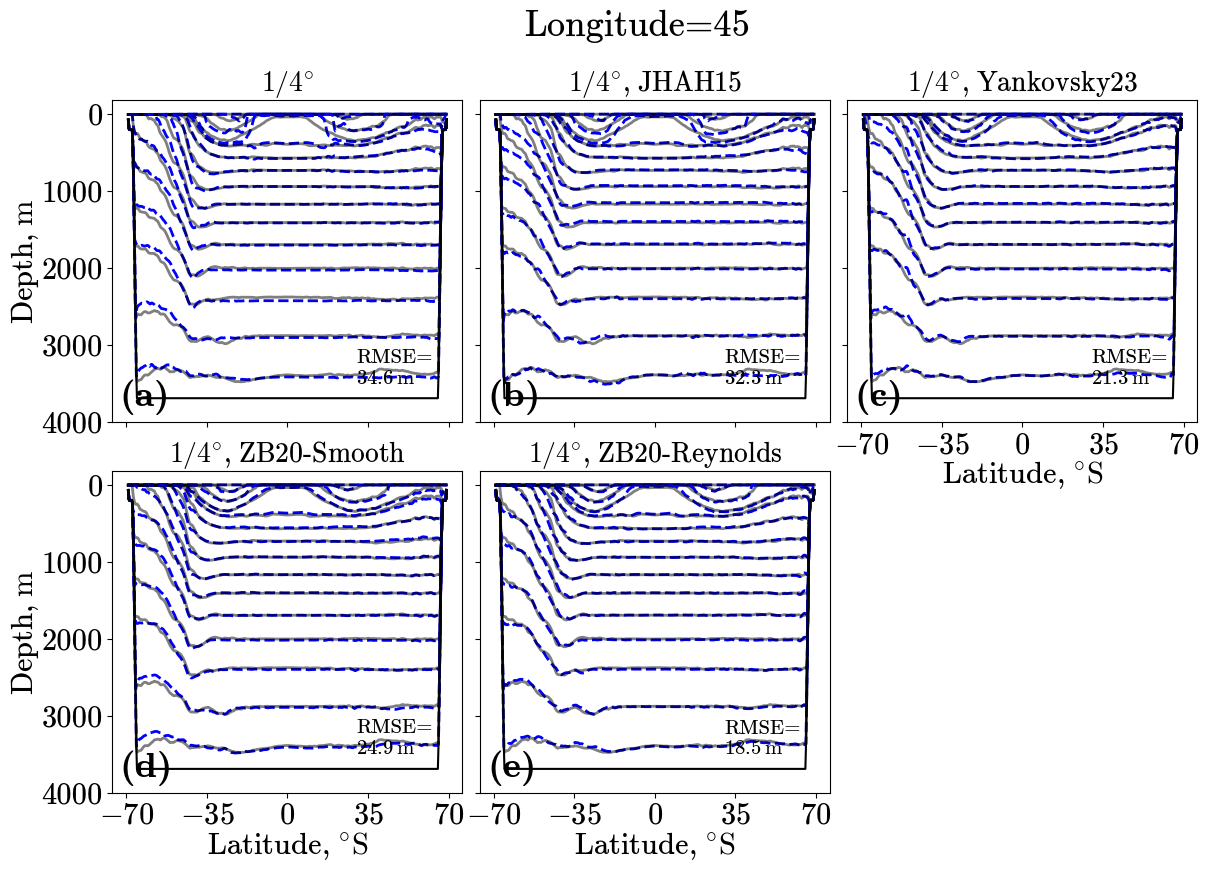

In [24]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(14,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_yankovsky_weak, e4_smooth_weak, e4_reynolds_weak], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,3,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    if col==1 or col==2 or col==4:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-70,-35,0,35,70], [None]*5)
    else:
        plt.xticks([-70,-35,0,35,70])

plt.suptitle('Longitude=45')

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('Review-2/lon45-weak.pdf')

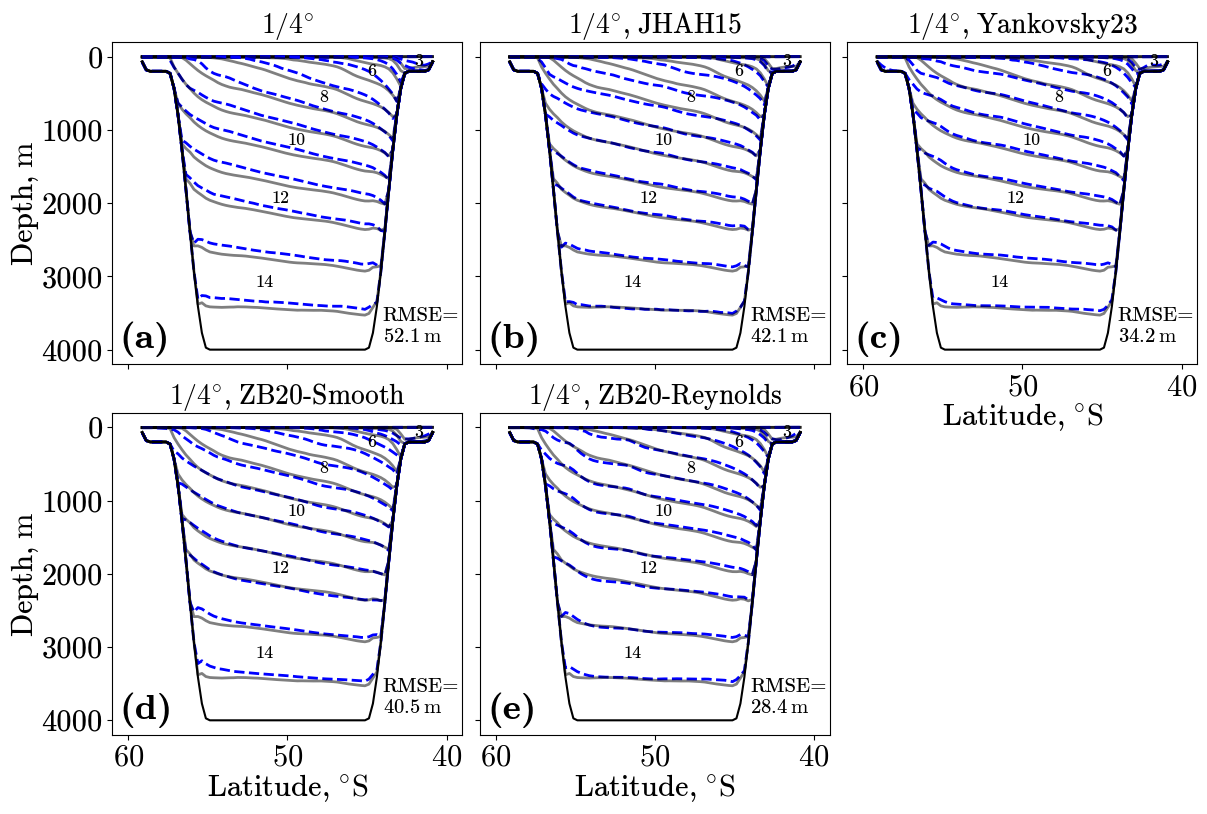

In [12]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(14,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_yankovsky_strong, e4_smooth_strong, e4_reynolds_strong], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,3,col+1)
    plot_interfaces_Drake(e, target=e32)
    plt.title(label, fontsize=20)
    if col==1 or col==2 or col==4:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-60, -50, -40], [None]*3)

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('Review-2/Drake-strong.pdf')

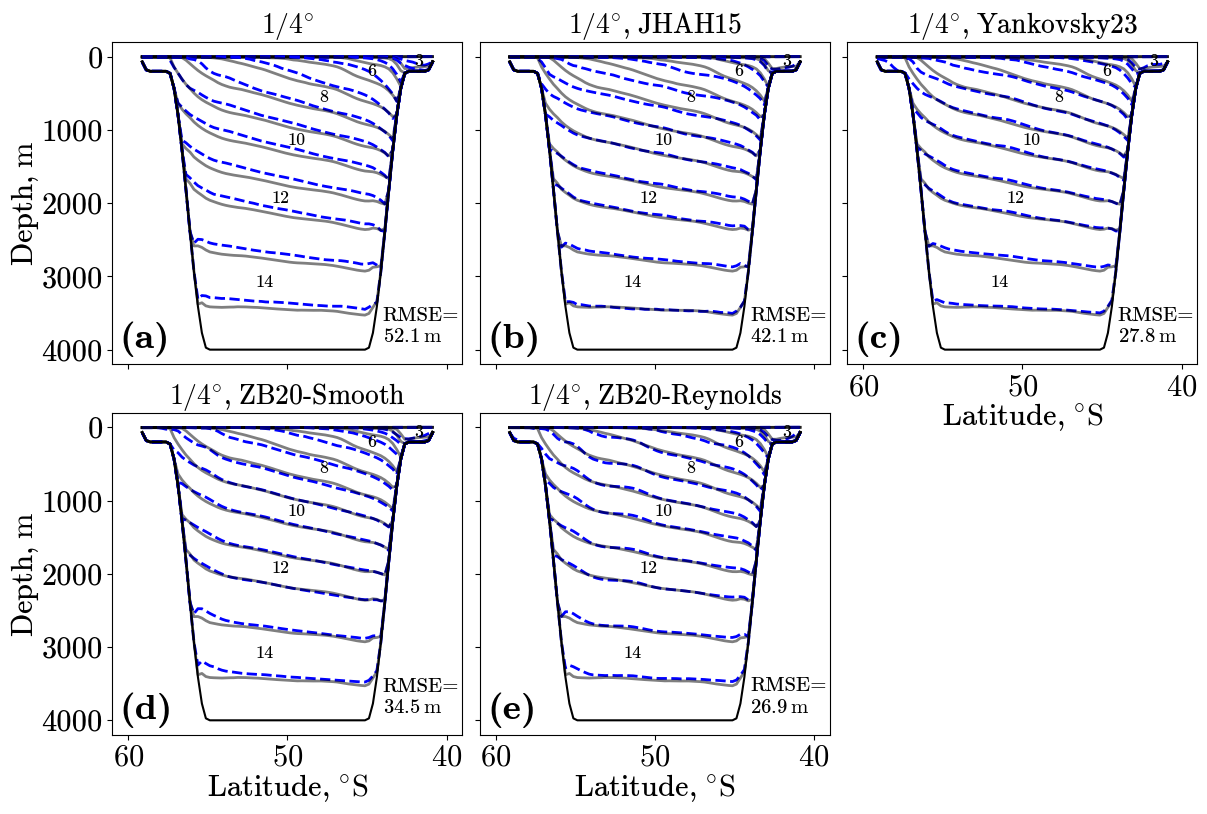

In [13]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(14,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_yankovsky_weak, e4_smooth_weak, e4_reynolds_weak], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,3,col+1)
    plot_interfaces_Drake(e, target=e32)
    plt.title(label, fontsize=20)
    if col==1 or col==2 or col==4:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-60, -50, -40], [None]*3)

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('Review-2/Drake-weak.pdf')

# SSH

In [26]:
ssh_32 = M32.e.isel(zi=0).mean('time').coarsen(xh=8,yh=8).mean().compute()
ssh_4 = M4.e.isel(zi=0).compute()

ssh_reynolds_weak = M4_reynolds_weak.e.isel(zi=0).compute()
ssh_smooth_weak = M4_smooth_weak.e.isel(zi=0).compute()
ssh_reynolds_strong = M4_reynolds_strong.e.isel(zi=0).compute()
ssh_smooth_strong = M4_smooth_strong.e.isel(zi=0).compute()

ssh_jh = M4_JH.e.isel(zi=0).compute()
ssh_yankovsky_strong = M4_yankovsky_strong.e.isel(zi=0).compute()
ssh_yankovsky_weak = M4_yankovsky_weak.e.isel(zi=0).compute()

In [27]:
for model in [ssh_4, 
              ssh_jh, ssh_yankovsky_strong, 
              ssh_smooth_strong, ssh_reynolds_strong]:
    error = model - ssh_32
    rmse = float(np.sqrt((error**2).mean()))
    print("{:.3f}".format(rmse))

0.101
0.110
0.079
0.099
0.087


In [28]:
for model in [ssh_4, 
              ssh_jh, ssh_yankovsky_weak, 
              ssh_smooth_weak, ssh_reynolds_weak]:
    error = model - ssh_32
    rmse = float(np.sqrt((error**2).mean()))
    print("{:.3f}".format(rmse))

0.101
0.110
0.071
0.090
0.080
